# AM205 Assignment 2

Andrew Ross

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import clock
import scipy.linalg

## 1. Norms and Newton root-finding

In [2]:
A = np.array([[3, -1],
              [1, 0]])

### (a) Finding $b$ such that $||b||_2 = ||Ab||_2 = 1$

If $b = \left(\begin{smallmatrix}x\\y\end{smallmatrix}\right)$, then we know $Ab = \left(\begin{smallmatrix}3x-y\\x\end{smallmatrix}\right)$.

Therefore we have a system of equations

$$
\begin{cases}
\sqrt{x^2 + y^2} = 1 \\
\sqrt{(3x-y)^2 + x^2} = 1
\end{cases}
$$

Which we can quickly rearrange to

$$
\begin{cases}
y^2 = 1 - x^2 \\
10x^2 - 6xy + y^2 = 1
\end{cases}
$$

This has immediately apparent solutions $y=\pm1, x=0$, and with a little extra work, we can show $9x^2 = 6x\sqrt{1-x^2}$, so $81x^2 = 36(1-x^2)$, and finally we have $x^2 = \frac{36}{117}$ and $y^2 = \frac{81}{117}$. $x$ and $y$ must both have the same sign for the $-6xy$ term to cancel the squared terms, so that gives us four points: $(0, 1)$, $(0, -1)$, $(\frac{6}{\sqrt{117}}, \frac{9}{\sqrt{117}})$, and $(-\frac{6}{\sqrt{117}}, -\frac{9}{\sqrt{117}})$.

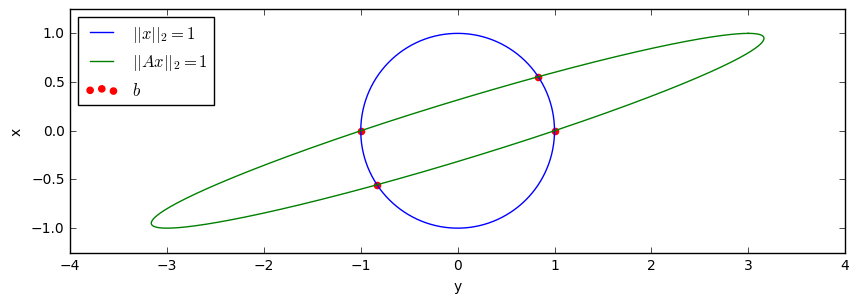

In [3]:
angle_domain = np.linspace(0, 2*np.pi, 500)
x_values = np.array([[np.cos(a), np.sin(a)] for a in angle_domain])
# I think this gives us flipped xs and ys, but it's better for plot dimensions
Ax_values = np.array([A.dot(x) for x in x_values])

def pom(a): return [a, -a]

b = np.array([
        [0, 1],
        [0, -1],
        [6/np.sqrt(117), 9/np.sqrt(117)],
        [-6/np.sqrt(117), -9/np.sqrt(117)]
    ])

plt.figure(figsize=(10,np.pi)) # close enough
plt.plot(x_values[:,0], x_values[:,1], label=r'$||x||_2=1$')
plt.plot(Ax_values[:,0], Ax_values[:,1], label=r'$||Ax||_2=1$')
plt.scatter(b[:,1], b[:,0], color='red', label=r'$b$')
plt.ylim((-1.25,1.25))
plt.xlim((-4,4))
plt.legend(loc='best')
plt.xlabel('y')
plt.ylabel('x')
plt.show()

Note that I reversed the traditional orientations of $y$ and $x$ because the aspect ratio works looks nicer for this notebook format.

### (b) Finding $c$ such that $||c||_\infty = ||Ac||_\infty = 1$

Here, we need to find $(x,y)$ such that both `max`$(|x|, |y|) = 1$ and `max`$(|3x-y|, |x|) = 1$. We can see very easily again that $(0, \pm1)$ satisfies these constraints, but when $x \neq 0$, we need $3x-y = \pm1$ and hopefully $|x|$ and $|y|$ work out to be $\leq 1$.

Since we need both equations to satisfy, we can plug in $y=\pm1$ to $3x-y = \pm1$, and we get $3x=2$ as well as $3x=-2$ as valid solutions. So $(\pm\frac{2}{3},\pm1)$ also work.

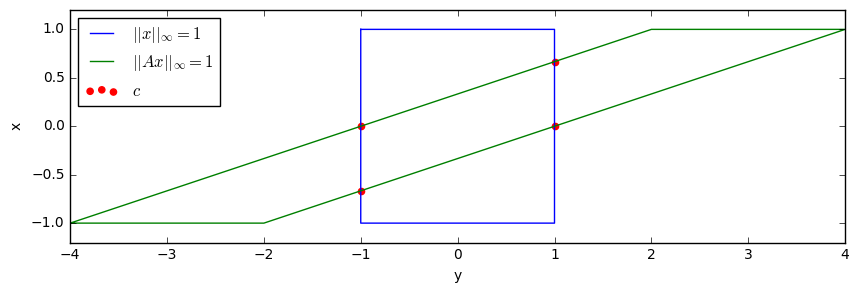

In [4]:
x_values = np.array(
      [[x, 1] for x in np.linspace(-1, 1, 500)]
    + [[1, y] for y in np.linspace(1, -1, 500)]
    + [[x, -1] for x in np.linspace(1, -1, 500)]
    + [[-1, y] for y in np.linspace(-1, 1, 500)])

Ax_values = np.array([A.dot(x) for x in x_values])
c = np.array([
        [0, 1],
        [0, -1],
        [2./3, 1],
        [-2./3, -1]
    ])

plt.figure(figsize=(10,3))
plt.plot(x_values[:,0], x_values[:,1], label=r'$||x||_\infty=1$')
plt.plot(Ax_values[:,0], Ax_values[:,1], label=r'$||Ax||_\infty=1$')
plt.scatter(c[:,1], c[:,0], color='red', label=r'$c$')
plt.ylim((-1.2,1.2))
plt.xlim((-4,4))
plt.legend(loc='best')
plt.xlabel('y')
plt.ylabel('x')
plt.show()

### (c) Newton's (vector-generalized) root finding method

In [5]:
def approximate_jacobian(f, d, h=1e-8):
    dx = f(d) - f(d + np.array([h, 0]))
    dy = f(d) - f(d + np.array([0, h]))
    return np.array([-dx/h, -dy/h]).T

def newton_root(f, x0, tol=1e-6):
    x = x0
    fx = f(x)
    while any(abs(el) > tol for el in fx):
        J = approximate_jacobian(f, x)
        x = np.add(x, np.linalg.solve(J, -fx))
        fx = f(x)
    return x

def all_newton_roots(f, grid, tol=1e-6):
    roots = []
    for x0 in grid:
        root = newton_root(f, x0, tol)
        if all(np.linalg.norm(r - root) > tol for r in roots): # dedup
            roots.append(root)
    return np.array(roots)

[[ -6.37289939e-01  -9.55934908e-01]
 [ -7.39072267e-11  -1.00000000e+00]
 [  6.37289939e-01   9.55934908e-01]
 [  3.68940869e-17   9.99999995e-01]]


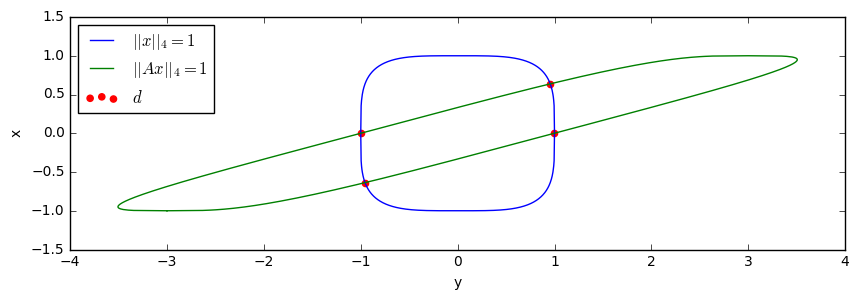

In [6]:
def f(d):
    return np.array([
        np.linalg.norm(d, ord=4) - 1,
        np.linalg.norm(A.dot(d), ord=4) - 1
    ])

x_values = np.array(
    [[x, (1 - x**4)**0.25] for x in np.linspace(-1, 1, 500)] +
    [[x, -(1 - x**4)**0.25] for x in np.linspace(1, -1, 500)])
Ax_values = np.array([A.dot(x) for x in x_values])

search_space = np.linspace(-1, 1, 25)
search_grid = [[x, y] for y in search_space for x in search_space]
d = all_newton_roots(f, search_grid)
print(d)

plt.figure(figsize=(10,3))
plt.plot(x_values[:,0], x_values[:,1], label=r'$||x||_4=1$')
plt.plot(Ax_values[:,0], Ax_values[:,1], label=r'$||Ax||_4=1$')
plt.scatter(d[:, 1], d[:, 0], color='red', label=r'$d$')
plt.xlabel('y')
plt.ylabel('x')
plt.legend(loc='best')
plt.show()

### (d) Two straight lines

If we return to the formula for the p-norm, we have

$$
||b||_p = (x^p + y^p)^\frac{1}{p} \\
||Ab||_p = ((3x-y)^p + x^p)^\frac{1}{p}
$$

Setting these equal, we obtain

$$
x^p + y^p = (3x-y)^p + x^p \\
\implies y^p = (3x-y)^p \\
\implies y = \pm (3x-y)
$$

This can be satisfied for some choice of $\pm$ if $x=0$, so the line $x=0$ should contain valid solutions. Otherwise, any point on the line $y = \frac{3}{2}x$ should satisfy $||b||_p = ||Ab||_p$. Let's plot this (returning to the proper x-y orientation):

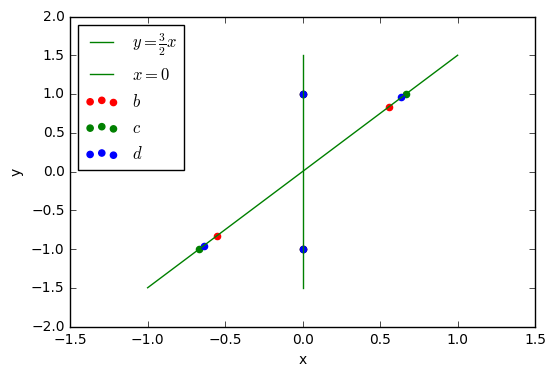

In [7]:
all_points = np.vstack((b,c,d))
assert(len(all_points) == 12)

plt.scatter(b[:,0], b[:,1], label=r'$b$', color='red')
plt.scatter(c[:,0], c[:,1], label=r'$c$', color='green')
plt.scatter(d[:,0], d[:,1], label=r'$d$', color='blue')
plt.plot([-1, 1], [-3/2., 3/2.], color='green', label=r'$y=\frac{3}{2}x$')
plt.plot([0, 0], [3/2, -3/2], color='green', label=r'$x=0$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

## 2. LU factorization for binary numbers

Let's grab Chris's `bin_mul` function first just for reference / eventual testing:

In [2]:
def bin_mul(c,d):  
    # Check that the dimensions of the matrices are compatible
    (m,n)=c.shape
    (nn,p)=d.shape
    if n!=nn:
        print("Matrix size mismatch")
        sys.exit()

    # Initalize blank matrix of integer zeros
    e=np.zeros((m,p),dtype=np.int8)

    # Calculate each term, using "&" instead of "*" and "^" instead of "+"
    for i in range(m):
        for j in range(p):
            for k in range(n):
                e[i,j]=e[i,j]^(c[i,k]&d[k,j])
    return e

# Also add a binary dot product function to help with testing later
def bin_dot(A, x):
    return bin_mul(A, np.array([x], dtype=np.int8).T)

### (a) `fsolve`

In [3]:
def fsolve(L, b):
    # Check we have a square matrix and b is the right length
    (m,n) = L.shape
    if m != n:
        raise ValueError("must pass a square matrix")
    if len(b) != n:
        raise ValueError("b must have same length as L")
    
    # Initialize result vector
    x = np.zeros(n, dtype=np.int8)
    
    for j in range(n):
        # make sure Ljj isn't 0. If it's 1, we can ignore it
        # since division is a noop, but if it's 0, we fail.
        if L[j][j] == 0:
            raise ValueError("L has 0 at position {}".format(j))
        
        # do the multiplications and subtractions of forward substitution
        x[j] = b[j]
        for k in range(j):
            x[j] = x[j] ^ (L[j][k] & x[k])
    
    return x

# some quick tests
L = np.array([[1, 0],
              [0, 1]], dtype=np.int8) 
b = np.array([1, 1], dtype=np.int8)
np.testing.assert_array_equal(fsolve(L, b), b) # solving with identity should echo b

L = np.array([[1, 0],
              [1, 1]], dtype=np.int8)
b = np.array([0, 1], dtype=np.int8)
np.testing.assert_array_equal(fsolve(L, b), b) # another case where we should echo a particular b

failed = False
L = np.array([[1, 0],
              [1, 0]], dtype=np.int8)
try: fsolve(L, b)
except ValueError: failed = True
assert(failed) # singular matrix should raise an error

### (b) `rsolve`

In [4]:
def rsolve(U, b):
    # Check we have a square matrix and b is the right length
    (m,n) = U.shape
    if m != n:
        raise ValueError("must pass a square matrix")
    if len(b) != n:
        raise ValueError("b must have same length as U")
    
    # Initialize result vector
    x = np.zeros(n, dtype=np.int8)
    
    for j in reversed(range(n)):
        # make sure Ujj isn't 0. If it's 1, we can ignore it
        # since division is a noop, but if it's 0, we fail.
        if U[j][j] == 0:
            raise ValueError("L has 0 at position {}".format(j))
        
        # do the multiplications and subtractions of forward substitution
        x[j] = b[j]
        for k in range(j+1, n):
            x[j] = x[j] ^ (U[j][k] & x[k])
    
    return x

# some more tests
U = np.array([[1, 0],
              [0, 1]], dtype=np.int8) 
b = np.array([1, 1], dtype=np.int8)
np.testing.assert_array_equal(rsolve(U, b), b)

U = np.array([[1, 1],
              [0, 1]], dtype=np.int8)
b = np.array([0, 1], dtype=np.int8)
np.testing.assert_array_equal(rsolve(U, b), np.array([1, 1], dtype=np.int8))

failed = False
U = np.array([[1, 0],
              [1, 0]], dtype=np.int8)
try: rsolve(U, b)
except ValueError: failed = True
assert(failed)

### (c) LU with partial pivoting

In [5]:
def binary_lu(A):
    (m,n) = A.shape
    if m != n:
        raise ValueError("must pass a square matrix")
    
    U = A.copy()
    L = np.identity(n, dtype=np.int8)
    P = np.identity(n, dtype=np.int8)
    for j in range(n-1):
        # Slightly ugly permutation code (forgive me)
        if not U[j][j]: # if we need to permute
            # find the first acceptable row
            i = j
            while not U[i][j] and i < n-1:
                i += 1
                
            # update P
            P[[i,j]] = P[[j,i]]
            
            # update L
            tmp = L[i, :j].copy()
            L[i, :j] = L[j, :j]
            L[j, :j] = tmp
            
            # update U
            tmp = U[i, j:].copy()
            U[i,j:] = U[j,j:]
            U[j,j:] = tmp

        # Now apply the normal LU operations with *->&  and +->^
        for i in range(j+1, n):
            L[i][j] = U[i][j] & U[j][j]
            for k in range(j, n):
                U[i][k] = U[i][k] ^ (L[i][j] & U[j][k])
    
    return L, U, P

# for I, should return 3 Is
I =  np.array([[1, 0],
               [0, 1]], dtype=np.int8) 
L, U, P = binary_lu(I)
np.testing.assert_array_equal(P, I)
np.testing.assert_array_equal(L, I)
np.testing.assert_array_equal(U, I)

# on an upper triangular matrix U, should return U + 2Is
A = np.array([[1, 1],
              [0, 1]], dtype=np.int8) 
L, U, P = binary_lu(A)
np.testing.assert_array_equal(P, I)
np.testing.assert_array_equal(L, I)
np.testing.assert_array_equal(U, A)

# on a lower triangular matrix L, should return L + 2Is
A = np.array([[1, 0],
              [1, 1]], dtype=np.int8) 
L, U, P = binary_lu(A)
np.testing.assert_array_equal(P, I)
np.testing.assert_array_equal(L, A)
np.testing.assert_array_equal(U, I)

# on a permutation P, it should return P^T + 2Is
A = np.array([[0, 1, 0],
              [0, 0, 1],
              [1, 0, 0]], dtype=np.int8) 
L, U, P = binary_lu(A)
np.testing.assert_array_equal(P, A.T)
np.testing.assert_array_equal(L, np.identity(3, dtype=np.int8))
np.testing.assert_array_equal(U, np.identity(3, dtype=np.int8))

### (d) Testing binary LU factorization on q2_small and q2_large

In [6]:
def read_binary_matrix(filename):
    with open(filename, 'r') as f:
        text = f.read().strip()
        A = np.array([[int(char) for char in line.split(' ')]
                                 for line in text.split('\n')],
                     dtype=np.int8)
    return A

def binary_lu_solve(A, b):
    L, U, P = binary_lu(A)
    return rsolve(U, fsolve(L, P.dot(b)))

A = read_binary_matrix('am205_hw2_files/q2_small/a.txt')
b = read_binary_matrix('am205_hw2_files/q2_small/b.txt')
x = binary_lu_solve(A, b)
np.testing.assert_array_equal(bin_dot(A, x), b)

print('Solution to q2_small: x =', x)

A = read_binary_matrix('am205_hw2_files/q2_large/a.txt')
b = read_binary_matrix('am205_hw2_files/q2_large/b.txt')
x = binary_lu_solve(A, b)
np.testing.assert_array_equal(bin_dot(A, x), b)

print('Solution to q2_large: x =', x)

Solution to q2_small: x = [1 0 1 0 1 0 1 0 1 0 1 0 1 0]
Solution to q2_large: x = [0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0]


## 3. The light game

### (a) Computing the toggling matrix

In [7]:
# Helper to translate i,j coords into 1D indexes into grid_size^2 
def grid_index(row, col, rows):
        return row + col * rows
assert(grid_index(0, 0, 7) == 0)
assert(grid_index(6, 6, 7) == 48)
    
# Helpers to select only i,j coords on the grid
def within_bounds(coords, rows, cols):
    row, col = coords
    return 0 <= row < rows and 0 <= col < cols

def grid_adjacencies(i, j, rows, cols):
    adjacencies = [[i+1, j], [i, j+1], [i-1, j], [i, j-1], [i, j]]
    return [a for a in adjacencies if within_bounds(a, rows, cols)]

assert(within_bounds([0, 0], 7, 7))
assert(not within_bounds([-1, 5], 7, 7))
assert(len(grid_adjacencies(0, 0, 7, 7)) == 3)

def light_press_toggling_matrix(rows, cols):    
    # Now we can finally construct the matrix
    A = np.zeros((rows*cols, rows*cols), dtype=np.int8)
    for row in range(rows):
        for col in range(cols):
            for i, j in grid_adjacencies(row, col, rows, cols):
                A[grid_index(row, col, rows)][grid_index(i, j, rows)] = 1
    return A
    
light_press_toggling_matrix(7, 7)

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int8)

### (b) Solving examples

Since this process is completely reversible, just setting $b$ to the starting light grid and solving for $x$ should give us the sequence of presses to turn them off.

In [8]:
# I'll write these out as normal arrays first,
# then flatten them (e.g. with numpy.ravel)

grid1 = np.array([
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0]], dtype=np.int8)

grid2 = np.zeros((7, 7), dtype=np.int8)
for i in range(7):
    grid2[0][i] = 1
    grid2[i][0] = 1
    grid2[6][i] = 1
    grid2[i][6] = 1

grid3 = np.zeros((7, 7), dtype=np.int8)
grid3[3][3] = 1

grid4 = np.zeros((7, 7), dtype=np.int8)
grid4[6][0] = 1

grid5 = np.zeros((7, 7), dtype=np.int8)
grid5[4][0] = 1

0111110101010111101111001001111011110101010111110
1000001001110001010100110110010101000111001000001
0001000001110001000101101011010001000111000001000
1100000001000010110001010100000111010000011101101
1011000100010001101100000101011101100101010001110


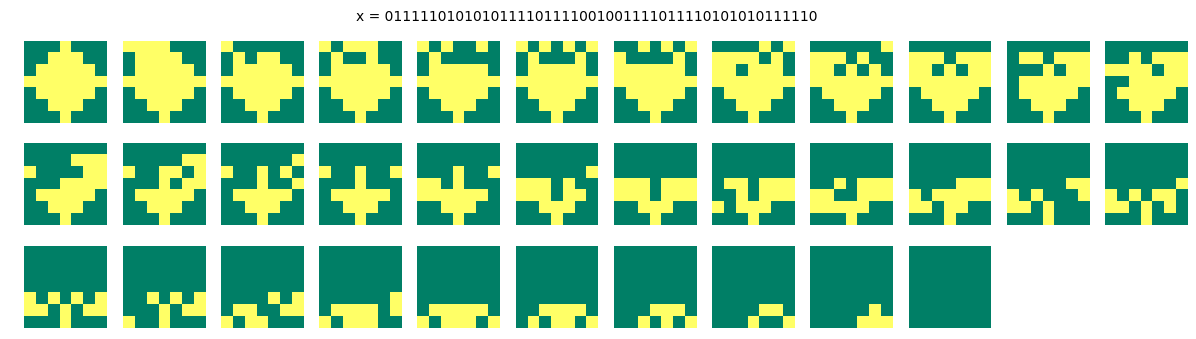

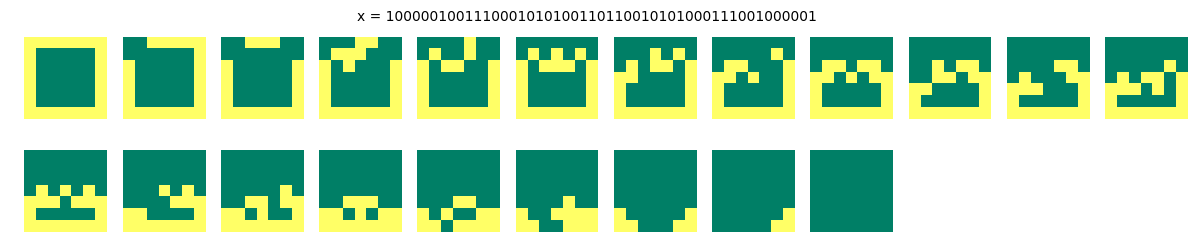

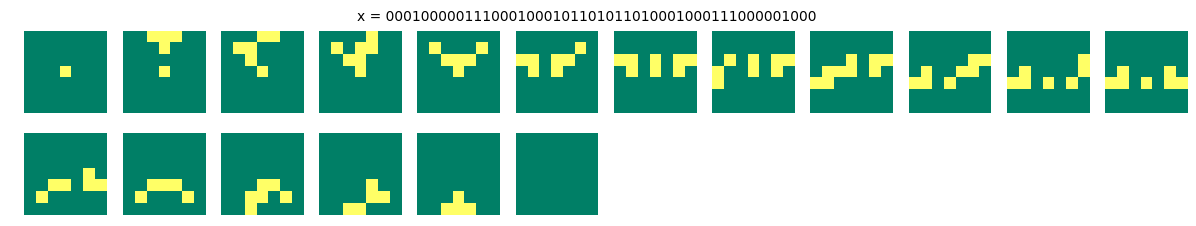

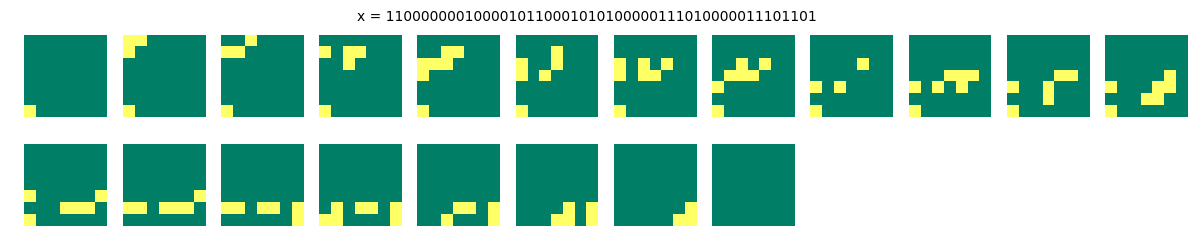

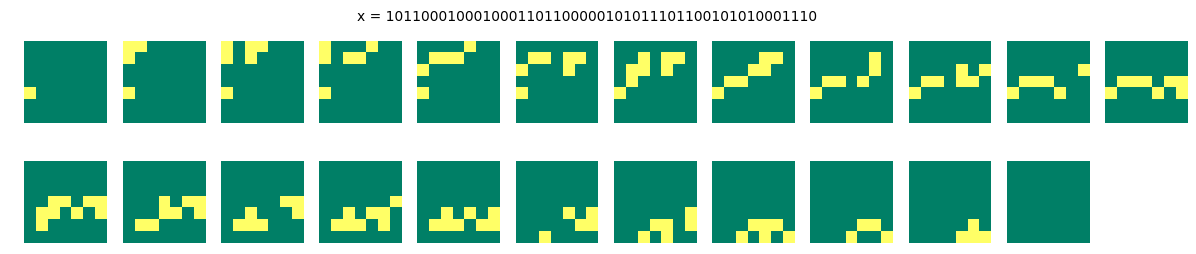

In [11]:
def plot_light_grid_solution(grid):
    # first solve for the right sequence of presses
    (n, m) = grid.shape
    A = light_press_toggling_matrix(n, m)
    b = np.ravel(grid.copy())
    x = binary_lu_solve(A, b)
    
    # plot the grid initially 
    n_fig_rows = sum(x) / 12 + 1
    n_fig_cols = 12
    n_presses = 1
    fig = plt.figure(figsize=(15,n_fig_rows))
    fig.suptitle('x = {}'.format(''.join([str(xx) for xx in x])))
    print(''.join([str(xx) for xx in x]))
    
    def spyplot(b, n_presses):
        fig.add_subplot(n_fig_rows, n_fig_cols, n_presses)
        plt.axis('off')
        plt.spy(b.reshape((n, m)), cmap='summer')
        
    spyplot(b, n_presses)

    # then for each press
    for i in range(len(x)):
        if x[i]:            
            # apply the individual press
            xe = np.zeros(len(x), dtype=np.int8)
            xe[i] = 1
            for j, bit in enumerate(bin_dot(A, xe)):
                b[j] = b[j] ^ bit
            # replot the grid
            n_presses += 1
            spyplot(b, n_presses)

plot_light_grid_solution(grid1)
plot_light_grid_solution(grid2)
plot_light_grid_solution(grid3)
plot_light_grid_solution(grid4)
plot_light_grid_solution(grid5)
plt.show()

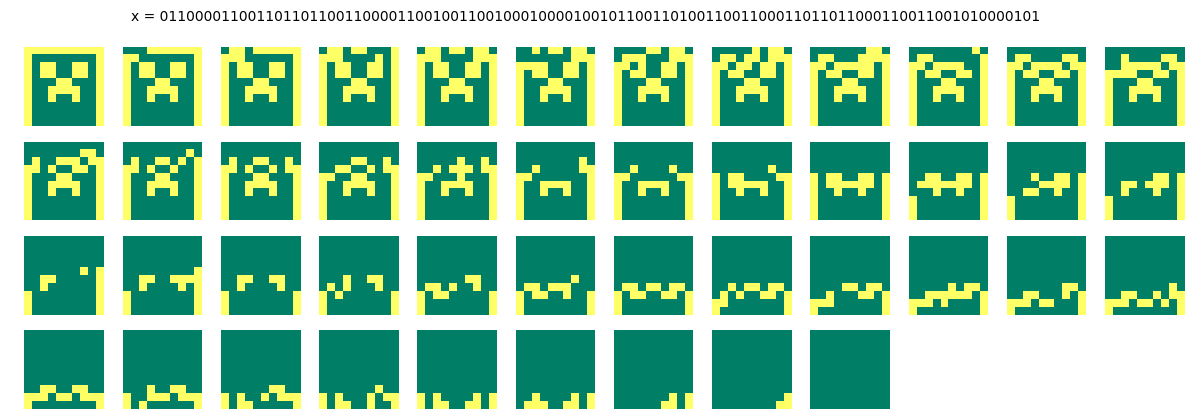

In [16]:
# My light pattern

def ascii_art_to_bin_grid(filename):
    with open(filename, 'r') as f:
        lines = f.read().strip().split('\n')
        m = max(len(line) for line in lines)
        n = len(lines)
        A = np.zeros((n, m), dtype=np.int8)
        for i, line in enumerate(lines):
            for j, char in enumerate(line):
                A[i][j] = int(char != ' ')
    return A        

grid6 = ascii_art_to_bin_grid('minecraft_creeper.txt')
plot_light_grid_solution(grid6)
plt.show()

### (c) Null space dimensions for more general $m \times n$ grids

In [17]:
def toggling_matrix_nullspace_dim(m, n):
    A = light_press_toggling_matrix(m, n)
    L,U,P = binary_lu(A) # LU decomposition will give us 0s in some L/U diagonals when A is singular.
    return sum(U[i][i] == 0 for i in range(m * n))

nullspace_dims = [[toggling_matrix_nullspace_dim(m, n) for m in range(1, 10)] for n in range(1, 10)]
nullspace_dims

[[0, 1, 0, 0, 1, 0, 0, 1, 0],
 [1, 0, 2, 0, 1, 0, 2, 0, 1],
 [0, 2, 0, 0, 3, 0, 0, 2, 0],
 [0, 0, 0, 4, 0, 0, 0, 0, 4],
 [1, 1, 3, 0, 2, 0, 4, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 6, 0],
 [0, 2, 0, 0, 4, 0, 0, 2, 0],
 [1, 0, 2, 0, 1, 6, 2, 0, 1],
 [0, 1, 0, 4, 1, 0, 0, 1, 8]]

I think the way to interpret the dimension of the nullspace of the toggling matrix is as follows:

For all of the zero entries at coordinate $m,n$ of this nullspace dimension matrix, i.e. grid sizes that have no nullspace, we know that for any light pattern on those $m \times n$ grids there is always a solution (or equivalently, a way to produce it), and disregarding press order, the way we solve it is unique.

For all of the nonzero enties, two things become true. First, we know there are certain light patterns we cannot produce/solve. However, for the patterns we can solve, we know there are multiple independent solutions, whose dimensionality is given by the dimension of the nullspace.

## 4. Difficult Cases for LU factorization

### (a) `generate_g`

In [18]:
def generate_g(n):
    G = np.identity(n)
    for i in range(1, n):
        for j in range(i):
            G[i][j] = -1
    # Originally I had the following, but it led to non-quadratic performance (actually better performance)
    #for i in range(1, n):
    #    G[i,:i] -= np.ones(i)
    G[:,n-1] = np.ones(n)
    return G

np.testing.assert_array_equal(generate_g(3), np.array([[ 1,  0, 1],
                                                       [-1,  1, 1],
                                                       [-1, -1, 1]]))

### (b) benchmarking

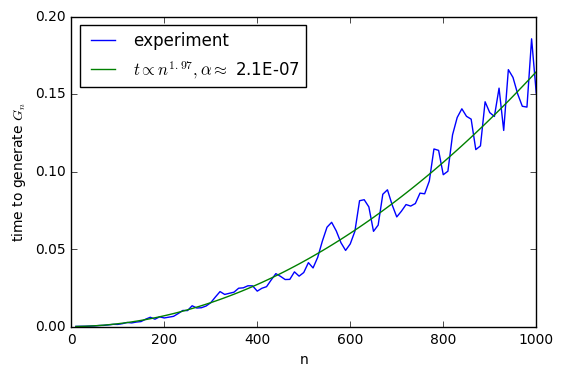

In [19]:
# find times to run generate_g
n_vals = range(10,1010,10)
t_vals = []
for n in n_vals:
    t0 = clock()
    generate_g(n)
    t1 = clock()
    t_vals.append(t1 - t0)

# do some linear regression on the log10-times
skip = 25 # the beginning is noisy
log_ns = np.array([np.log10(x) for x in n_vals[skip:]])
log_ts = np.array([np.log10(t) for t in t_vals[skip:]])
A = np.vstack([log_ns, np.ones(len(log_ns))]).T
beta, logalpha = np.linalg.lstsq(A, log_ts)[0]
alpha = 10**logalpha
fitted_t_vals = [alpha * n**beta for n in n_vals]

# plot
plt.plot(n_vals, t_vals, label='experiment')
plt.plot(n_vals, fitted_t_vals, label=r'$t \propto n^{{{:.2f}}}, \alpha \approx$ {:.1E}'.format(beta, alpha))
plt.xlabel('n')
plt.ylabel(r'time to generate $G_n$')
plt.legend(loc='best')
plt.show()

This makes sense; we're filling in the triangular bottom portion of $G$ with $-1$s, which has $n(n-1)/2$ values (including the diagonal, although we're using numpy to generate the identity), so the number of subtractions should grow quadratically.

### (c) Relative error of $G_n\hat{x} = b$

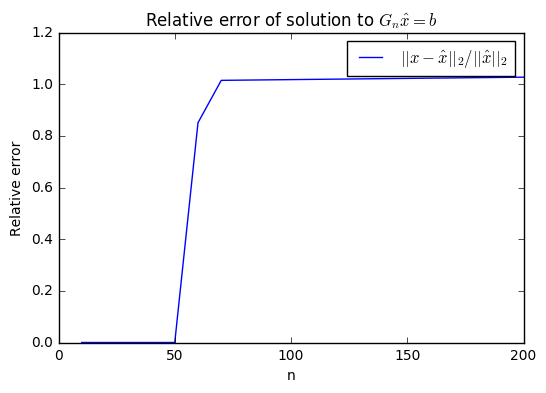

In [20]:
n_vals = range(10,210,10)
errors = []

for n in n_vals:
    G = generate_g(n)
    x = np.ones(n)
    b = G.dot(x)
    xh = np.linalg.solve(G, b) # uses LU under the hood
    errors.append(np.linalg.norm(x - xh) / np.linalg.norm(xh))
    
plt.title(r'Relative error of solution to $G_n\hat{x} = b$')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.plot(n_vals, errors, label=r'$||x-\hat{x}||_2/||\hat{x}||_2$')
plt.legend()
plt.show()

I included intermediate values between 10 and 200 because I was curious, I hope that's okay.

It wasn't obvious to me initially why this behavior would occur, so I looked quickly at the values of $U$ in the LU decomposition for these matrices $G_n$:

In [21]:
P, L, U = scipy.linalg.lu(generate_g(10))
print('L, n=10:')
print(L, '\n')
print('Cond. number of U, n=10:', np.linalg.cond(U))
print('Last column of U, n=10:', U[:,-1], '\n')
P, L, U = scipy.linalg.lu(generate_g(32))
print('Cond. number of U, n=32:', np.linalg.cond(U))
print('Last column of U, n=32:', U[:,-1])

L, n=10:
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1.  1.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1.  1.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.  1.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1.  1.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  1.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.]] 

Cond. number of U, n=10: 682.666503906
Last column of U, n=10: [   1.    2.    4.    8.   16.   32.   64.  128.  256.  512.] 

Cond. number of U, n=32: 2863311530.67
Last column of U, n=32: [  1.00000000e+00   2.00000000e+00   4.00000000e+00   8.00000000e+00
   1.60000000e+01   3.20000000e+01   6.40000000e+01   1.28000000e+02
   2.56000000e+02   5.12000000e+02   1.02400000e+03   2.04800000e+03
   4.09600000e+03   8.19200000e+03   1.63840000e+04   3.27680000e+04
   6.55360000e+04   1.31072000e+05   2.62144000e+05   5.24288000e+05
   1.04857600e+06   2.0

Because $L$ is full of negative values, in order for the final column values in $LU$ to all be 1, they need to get progressively doubled. In fairly short order, we end up with too many digits for the floating point numbers to fully store, and any errors we make propogate down that final column and blow up.

### (d) Checking numerical error against bounds

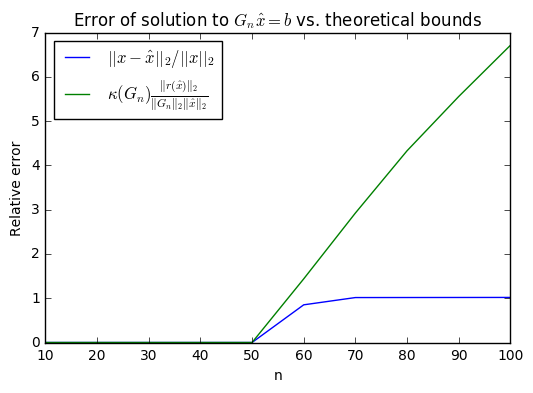

In [22]:
n_vals = range(10,110,10)
errors = []
bounds = []

for n in n_vals:
    G = generate_g(n)
    x = np.ones(n)
    b = G.dot(x)
    xh = np.linalg.solve(G, b) # uses LU under the hood
    errors.append(np.linalg.norm(x - xh) / np.linalg.norm(xh))
    bounds.append(
        np.linalg.cond(G) * np.linalg.norm(b - G.dot(xh)) / (
            np.linalg.norm(G) * np.linalg.norm(xh)
        )
    )
    
plt.title(r'Error of solution to $G_n\hat{x} = b$ vs. theoretical bounds')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.plot(n_vals, errors, label=r'$||x-\hat{x}||_2/||x||_2$')
plt.plot(n_vals, bounds, label=r'$\kappa(G_n)\frac{\|r(\hat x)\|_2}{\|G_n\|_2\|\hat x\|_2}$')
plt.legend(loc='best')
plt.show()

## 6. New Hampshire leaf identification

In [23]:
from matplotlib.image import imread

def read_leaf(i):
    image = imread('am205_leaves_534x420/main/leaf{0:03d}.png'.format(i))
    return 1 - np.ravel(image)

foliage = np.array([read_leaf(i) for i in range(143)])

### (a) Plotting the average leaf

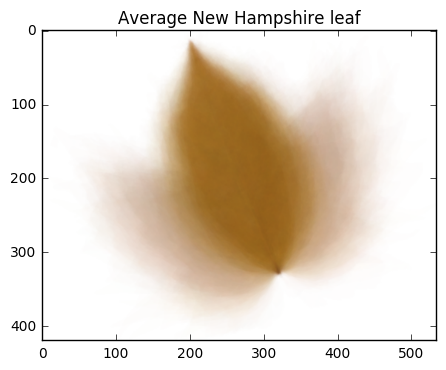

In [24]:
def plot_leaf(leaf):
    plt.imshow((1 - leaf.reshape(420, 534, 3).clip(min=0, max=1)))
    
mean_leaf = np.mean(foliage, axis=0)

plt.title('Average New Hampshire leaf')
plot_leaf(mean_leaf)
plt.show()

### (b) Reduced SVD

In [45]:
A = (foliage - mean_leaf).T
U, s, V = np.linalg.svd(A, full_matrices=False)

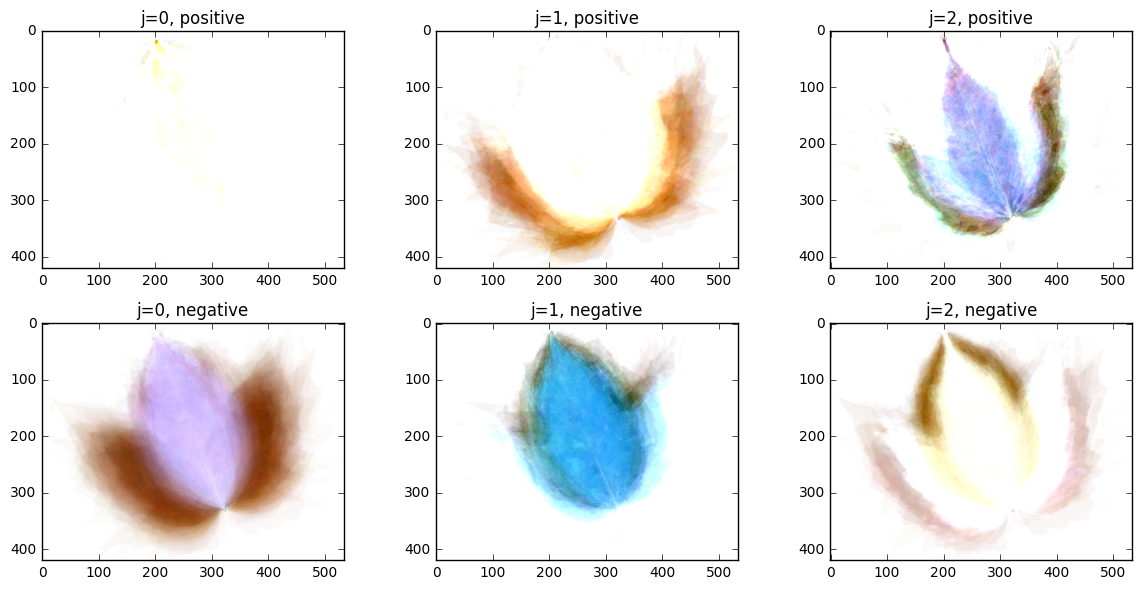

In [26]:
def scaled_neg_component(u): return (u / u.min()).clip(min=0)
def scaled_pos_component(u): return (u / u.max()).clip(min=0)

figleaf = plt.figure(figsize=(12, 6))

for j in [0, 1, 2]:
    figleaf.add_subplot(2,3,j+1)
    plt.title('j={}, positive'.format(j))
    plot_leaf(scaled_pos_component(U[:,j]))
    figleaf.add_subplot(2,3,j+4)
    plt.title('j={}, negative'.format(j))
    plot_leaf(scaled_neg_component(U[:,j]))
    
plt.tight_layout()
plt.show()

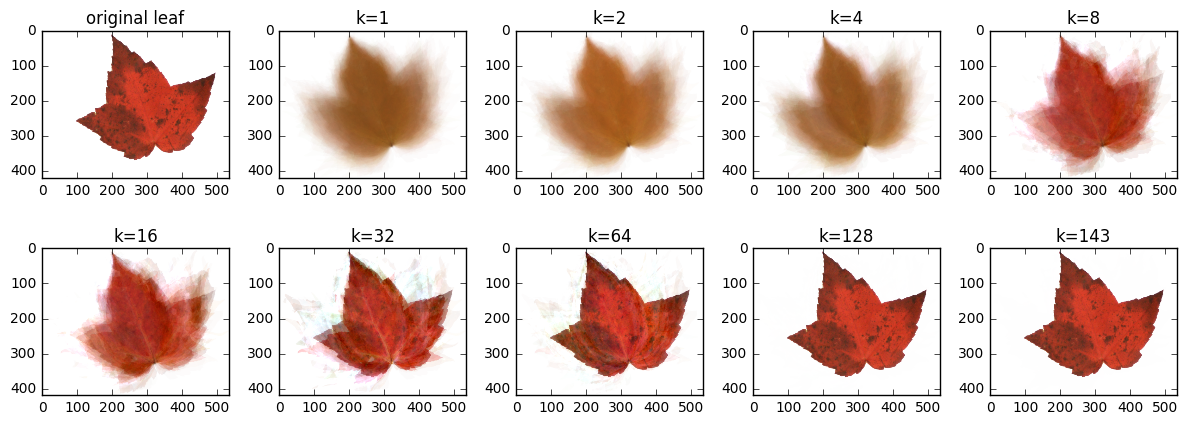

In [27]:
def svd_shadow_cast_by(leaf, n_dimensions, mean_leaf=mean_leaf, U=U):
    shadow = 0
    for j in range(n_dimensions):
        shadow += U[:,j].dot(leaf) * U[:,j]
    return shadow + mean_leaf

leaf = A.T[15]

fig = plt.figure(figsize=(12, 4.5))

# orig
fig.add_subplot(2,5,1)
plt.title('original leaf')
plot_leaf(leaf + mean_leaf)

# powers of 2
for k in range(8):
    fig.add_subplot(2,5,k+2)
    plt.title('k={}'.format(2**k))
    plot_leaf(svd_shadow_cast_by(leaf, 2**k))
    
# max
fig.add_subplot(2,5,10)
plt.title('k=143')
plot_leaf(svd_shadow_cast_by(leaf, 143))

plt.tight_layout()
plt.show()

We need a few more principal components than I expected to reconstruct a really vivid leaf image, but at around 32-64 dimensions, despite some noisy visual artifacts, we can clearly make out the original leaf, right down to the spots. This suggests we can compress our leaves by about a factor of ~3 and still clearly distinguish them later.

### (d) Leaf distances

In [28]:
def distance_between_leaf_and_projection(leaf, n_dimensions=8):
    return np.linalg.norm(leaf - svd_shadow_cast_by(leaf, n_dimensions)) / float(len(leaf))

distances = [distance_between_leaf_and_projection(leaf) for leaf in A.T]

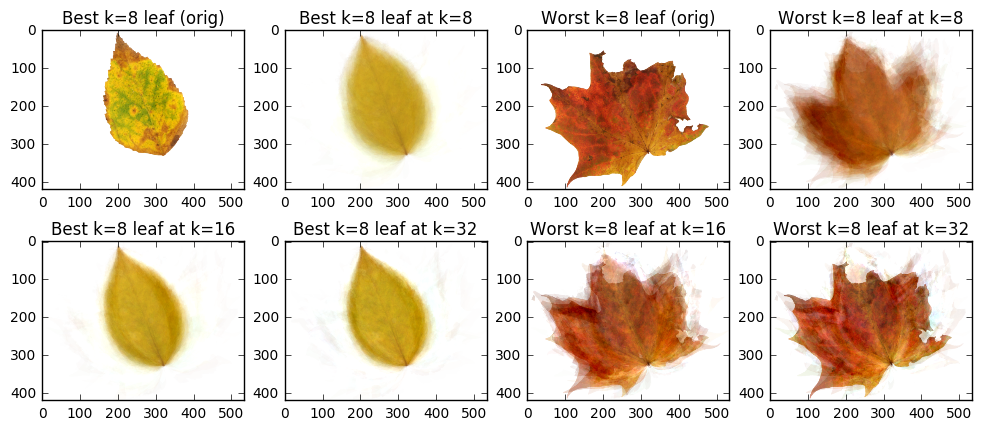

In [29]:
min_dist = min(distances)
max_dist = max(distances)
j_lo = distances.index(min_dist)
j_hi = distances.index(max_dist)

fig = plt.figure(figsize=(12,5))
fig.add_subplot(241)
plt.title('Best k=8 leaf (orig)')
plot_leaf(A.T[j_lo] + mean_leaf)
fig.add_subplot(242)
plt.title('Best k=8 leaf at k=8')
plot_leaf(svd_shadow_cast_by(A.T[j_lo], 8))
fig.add_subplot(245)
plt.title('Best k=8 leaf at k=16')
plot_leaf(svd_shadow_cast_by(A.T[j_lo], 16))
fig.add_subplot(246)
plt.title('Best k=8 leaf at k=32')
plot_leaf(svd_shadow_cast_by(A.T[j_lo], 32))
fig.add_subplot(243)
plt.title('Worst k=8 leaf (orig)')
plot_leaf(A.T[j_hi] + mean_leaf)
fig.add_subplot(244)
plt.title('Worst k=8 leaf at k=8')
plot_leaf(svd_shadow_cast_by(A.T[j_hi], 8))
fig.add_subplot(247)
plt.title('Worst k=8 leaf at k=16')
plot_leaf(svd_shadow_cast_by(A.T[j_hi], 16))
fig.add_subplot(248)
plt.title('Worst k=8 leaf at k=32')
plot_leaf(svd_shadow_cast_by(A.T[j_hi], 32))
plt.show()

These make a fair amount of intuitive sense for what would be the best and worst-reconstructed leaves at 8 principal components. The worst leaf not only one of the most highly complex types of leaves, but it's also torn, which would make its shape probably fairly unique in the dataset. It also looks slightly misaligned; its tip doesn't quite line up with the other leaves. So it's sort of an outlier in our leaf pile. It makes sense, then, that it would be difficult to reconstruct with principal components, which capture overall features.

The best-reconstructed leaf is extremely simple, shape- and orientation-wise. It's convext except at tiny length-scales, nicely compact, and perfectly aligned. Due to its lower "entropy" it's likely that that individual examples of that type of leaf (I think that shape may be called "elliptic") display less variation than examples from other types of leaves. They may also be less likely to tear.

Also, it's interesting to consider which types of leaves are most conducive for humans to digitize. Perhaps elliptic leaves are not only simpler, but easier to align for scanning :) 

### (e) Predicting NH vs. Cambridge leaves

I'm going to try using a large number of components for this problem, since only using a couple didn't lead to a big split in the distances.

In [30]:
leave_out_data = [1 - np.ravel(imread('am205_leaves_534x420/extra/leaf{0:03d}.png'.format(i))) for i in range(143,151)]
assert(len(leave_out_data) == 8)

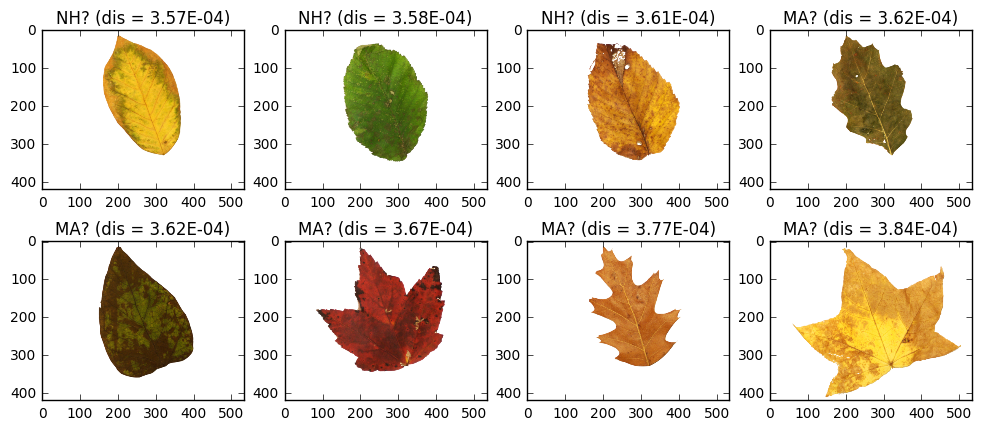

In [31]:
extra_distances = [distance_between_leaf_and_projection(leaf - mean_leaf, 64) for leaf in leave_out_data]
predicted_nh_leaves = sorted(zip(extra_distances, leave_out_data))[:3]
predicted_ma_leaves = sorted(zip(extra_distances, leave_out_data))[3:]

fig = plt.figure(figsize=(12,5))
for i, dl in enumerate(sorted(zip(extra_distances, leave_out_data))):
    dist, leaf = dl
    fig.add_subplot(2,4,i+1)
    state = 'NH' if i < 3 else 'MA'
    plt.title('{}? (dis = {:.2E})'.format(state, dist))
    plot_leaf(leaf)    
plt.show()

This could be correct, although I worry a little bit that we're mostly just rewarding simple, elliptic leaves, rather than actually pulling out the ones from NH. The first two leaves, though, clearly resemble some of the leaves in our sample, so maybe we did ok.

In [47]:
leaf_lens = np.genfromtxt('am205_leaves_534x420/leaf_len.txt', delimiter=' ')[:, 1]
leaf_diffs = U.T[:,k].dot((foliage - mean_leaf).T)

(143,)